# Variational Autoencoders

The Variational Autoencoder (VAE) will be trained on the MNIST dataset and see how it is able to generate new images.

In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from IPython import display

In [2]:
# Define global constants to be used in this notebook
BATCH_SIZE=1000
LATENT_DIM=2 # the dimension of the latent presentation of the input image, use "2" is easier to visualize

# prepare the dataset

In [3]:
splits, info = tfds.load('mnist', as_supervised=True, split=['train', 'test'], with_info=True, data_dir='./mnist')

Metal device set to: Apple M2


2022-10-21 15:41:34.669119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-21 15:41:34.669390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
train_data, test_data = splits
train_num_example = info.splits['train'].num_examples
test_num_example = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
image_size = info.features['image'].shape

print('training examples: ', train_num_example)
print('test examples: ', test_num_example)
print('num_classes: ', num_classes)
print('image_size: ', image_size)

training examples:  60000
test examples:  10000
num_classes:  10
image_size:  (28, 28, 1)


In [5]:
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    return image, label

In [6]:
train_dataset_batches = train_data.map(format_image).shuffle(1024).batch(BATCH_SIZE)
test_dataset_batches = test_data.map(format_image).batch(BATCH_SIZE)

## Build the Model

The main architecture of the VAR is shown as:

<img src="./imgs/vae_overview.png" width="60%" height="60%"/>

the VAE has an encoder-decoder architecture with the grey box in the middle which stands for the latent representation. In this layer, the model mixes a random sample and combines it with the outputs of the encoder. This mechanism makes it useful for generating new content.

## customize the sampling layer

This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

where $\mu$ = mean, $\sigma$ = standard deviation, and $\epsilon$ = random sample

In [7]:
# encoder model output (latent representation)
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

We will follow the architecture shown in class which looks like this. Note that aside from mu and sigma, we need to  also output the shape of features before flattening it. This will be useful when reconstructing the image later in the decoder.

<img src="./imgs/vae_encoder.png" width="60%" height="60%"/>

In [8]:
def encoder_layers(inputs, latent_dim):
    
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='SAME', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='SAME', activation='relu')(x)
    batch2 = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch2)
    x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)
    
    return mu, sigma, batch2.shape

def encoder_model(latent_dim, input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    mu, sigma, batch_shape = encoder_layers(inputs, latent_dim)
    z = Sampling()((mu, sigma))
    model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])
    
    return model, batch_shape

### Decoder

Next, build the decoder part of the network which expands the latent representations back to the original image dimensions. As you'll see later in the training loop, we can feed random inputs to this model and it will generate content that resemble the training data.

In [9]:
def decoder_layers(inputs, conv_shape):
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding='SAME', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                        padding='same', activation='sigmoid', name="decode_final")(x)

    return x

def decoder_model(latent_dim, conv_shape):
    
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = tf.keras.Model(inputs, outputs)
    
    return model

### Kullback–Leibler Divergence
To improve the generative capability of the model, we have to take into account the random normal distribution introduced in the latent space. For that, the [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) is computed and added to the reconstruction loss. The formula is defined in the function below.

In [10]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    
    
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation
    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5
    
    return kl_loss

### VAE Model

Note the use of `model.add_loss()` to add the KL reconstruction loss. Computing this loss doesn't use `y_true` and `y_pred` so it can't be used in `model.compile()`. 

In [11]:
def vae_model(encoder, decoder, input_shape):
    
    inputs = tf.keras.layers.Input(input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)
    
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)
    
    return model

In [12]:
def get_models(input_shape, latent_dim):
    
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    
    return encoder, decoder, vae

In [13]:
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

## Train the Model

In [14]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [15]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images
  
    Args:
  
    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (16, LATENT_DIM)
    """
  
    # generate images from the test input
    predictions = model.predict(test_input)
  
    # plot the results
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
  
    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

In [17]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
epochs = 100

generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    for step, (x_batch_train, _) in enumerate(train_dataset_batches):
        
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784
            loss += sum(vae.losses)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        loss_metric(loss)
        if step % 100 == 0:
            display.clear_output(wait=False)    
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

In [18]:
# train the model using the above codes or load the pre-trained weights
encoder.load_weights('./saved_weights/vae_mnist_encoder_weights.h5')
decoder.load_weights('./saved_weights/vae_mnist_decoder_weights.h5')
vae.load_weights('./saved_weights/vae_mnist_weights.h5')

In [ ]:
# save weights
# vae.save_weights('./vae_mnist_weights.h5')
# encoder.save_weights('./vae_mnist_encoder_weights.h5')
# decoder.save_weights('./vae_mnist_decoder_weights.h5')

### visualize the resconstruction image

In [37]:
# visualize the resconstructu
IMAGE_SIZE = 28
def display_one_row(disp_images, offset, shape=(IMAGE_SIZE, IMAGE_SIZE)):
    '''Displays a row of images.'''
    for idx, image in enumerate(disp_images):
        plt.subplot(2, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        image = np.reshape(image, shape)
        plt.imshow(image,cmap='binary')


def display_results(disp_input_images, disp_predicted):
    '''Displays input and predicted images.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,1))
    display_one_row(disp_predicted, 10, shape=(IMAGE_SIZE,IMAGE_SIZE,1))

1/1 [==============================] - 0s 42ms/step


2022-10-21 15:51:18.627095: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-21 15:51:18.821329: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


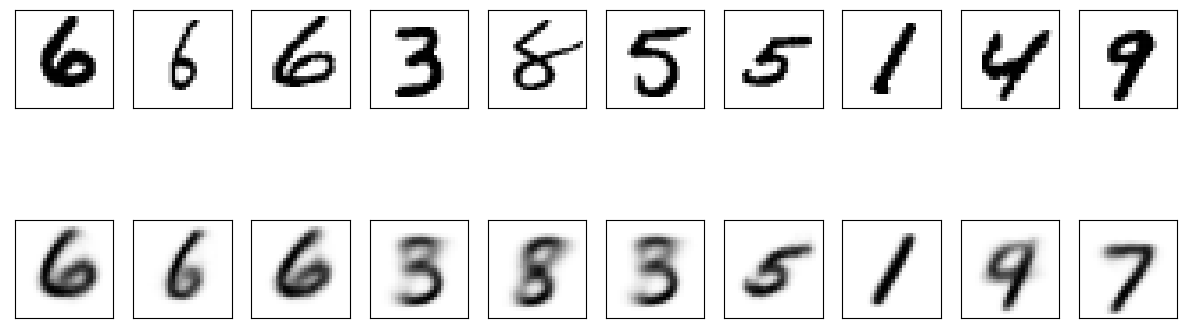

In [39]:
test_dataset = test_dataset_batches.take(1)
output_samples = []

for input_image, _ in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])
plt.savefig('./imgs/mnist_reconstructure.jpg')

# visualize the 2d latent representation

32/32 [==============================] - 0s 2ms/step


2022-10-21 15:51:25.323194: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


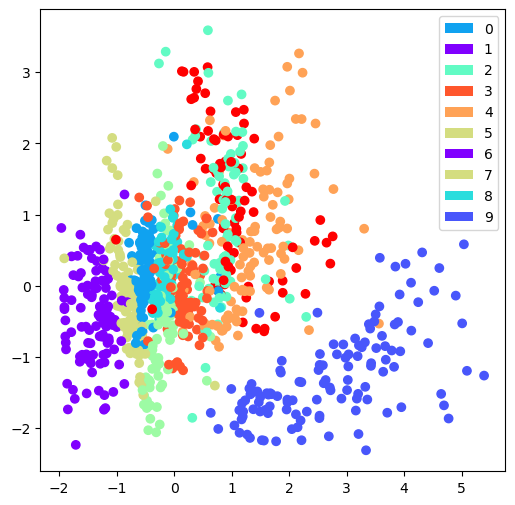

In [40]:

sample_dataset = next(iter(test_dataset_batches))
X_train, labels = sample_dataset
_, _, z = encoder.predict(X_train)

z1, z2 = z.T[0], z.T[1]

colors = plt.cm.rainbow(np.linspace(0, 1, 10))
cs = [colors[y] for y in labels]
classes = list(range(10))

recs = []
for i in range(0, len(cs)):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=cs[i]))

fig_dist = plt.figure(figsize=(6, 6))
ax_dist = fig_dist.add_subplot(111)
ax_dist.legend(recs, classes, loc=0)
ax_dist.scatter(z1, z2, color=cs)
plt.savefig('./imgs/mnist_reconstructed.jpg')